<a href="https://colab.research.google.com/github/shahargonda/TierraSpec_Clay_Prediction/blob/main/TierraSpec_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting clay presentage within soil samples, using lab spectroscopy information  
## Home assignment for TierraSpec

### Shahar Gonda, shahargonda@gmail.com
Data source: a part of the SSL database, provided by Prof. Eyal Ben-Dor


General Intentions:

* Exploring the original signal
* Creating a derivative signal
* Creating a normalized signal
* Optional PCA dimentionality reduction 
* Training a RF regressor on each
* Evaluating feature importance 
* Model ensable 

Some expectation about where the information lies: 

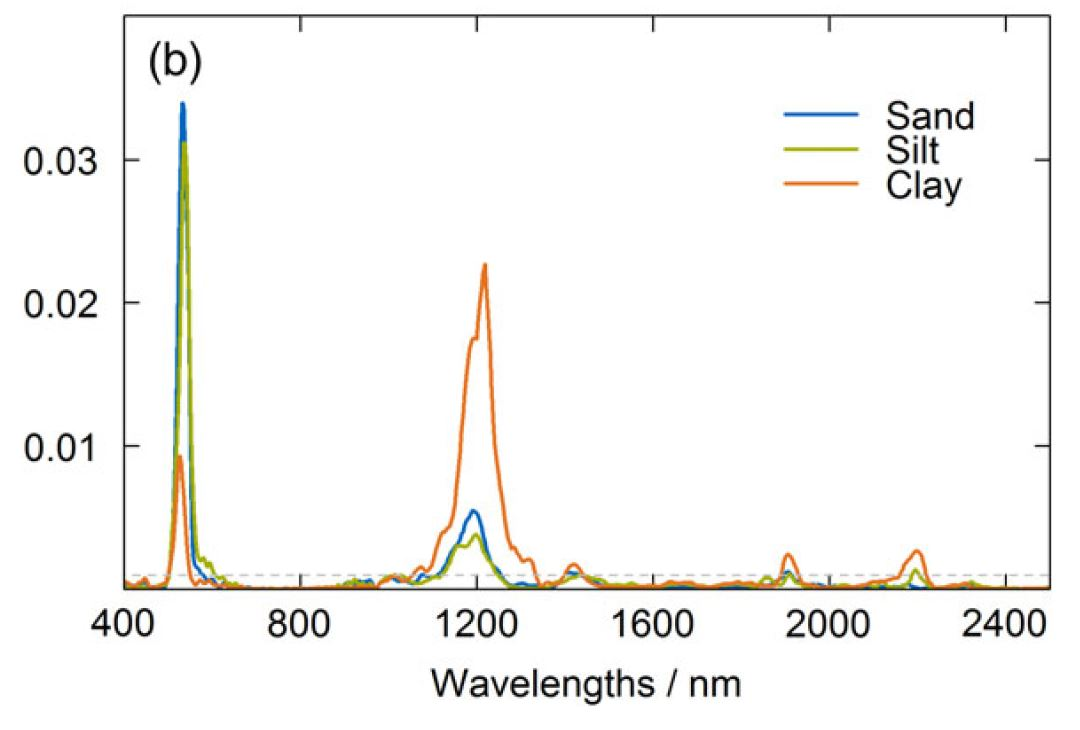

source: Hobley, E. U., & Prater, I. (2019)

In [1]:
# some imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor #RF
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

#from sklearn #ensamble

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# continous sratification
!pip install verstack
import verstack
from verstack.stratified_continuous_split import scsplit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# open file
data_path= '/content/Eyal_SL.csv'
df= pd.read_csv(data_path)

# show example of lines
df.head()

# basic statistics 
df.describe()
df.info()
# verify that there are no missing values
df.isnull( ).sum().sum()


,sample,Sand (% wt.),Silt (% wt.),Clay (% wt.),CaCO3 (%),Organic Matter (%),350,351,352,353,...,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367
0,A1,26.1449,40.3139,33.5412,0.50,6.65,0.058422,0.068922,0.072522,0.077222,...,0.288883,0.288818,0.288725,0.288647,0.288581,0.288504,0.288421,0.288327,0.288197,0.288059
1,A2,24.9016,30.0612,45.0372,5.86,6.65,0.061270,0.058670,0.066270,0.074370,...,0.294200,0.294186,0.294177,0.294140,0.294088,0.294040,0.293990,0.293943,0.293898,0.293842
2,A3,35.4214,26.9078,37.6709,2.06,13.23,0.062381,0.066081,0.079381,0.089981,...,0.253711,0.253656,0.253601,0.253549,0.253501,0.253454,0.253395,0.253322,0.253253,0.253195
3,A4,35.1233,18.7831,46.0936,8.46,5.65,0.071068,0.067994,0.075068,0.082714,...,0.272205,0.272157,0.272086,0.272015,0.271941,0.271869,0.271791,0.271694,0.271580,0.271461
4,A5,30.4319,15.3606,54.2075,8.48,2.52,0.091343,0.087419,0.088219,0.094419,...,0.356833,0.356781,0.356726,0.356701,0.356672,0.356610,0.356533,0.356457,0.356367,0.356268


,Sand (% wt.),Silt (% wt.),Clay (% wt.),CaCO3 (%),Organic Matter (%),350,351,352,353,354,...,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,...,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,50.308565,20.506474,29.184951,29.250000,2.788876,0.106276,0.108636,0.108219,0.108354,0.109670,...,0.498838,0.498784,0.498695,0.498604,0.498526,0.498410,0.498275,0.498135,0.498004,0.497795
std,22.706967,13.253734,15.125953,21.310459,2.244191,0.045737,0.045868,0.044396,0.043796,0.044469,...,0.161009,0.160990,0.160954,0.160956,0.160925,0.160913,0.160897,0.160885,0.160870,0.160824
min,4.030300,0.000000,4.126000,0.000000,0.090000,0.041900,0.040900,0.045500,0.047000,0.043900,...,0.193000,0.193000,0.193000,0.193000,0.193000,0.193000,0.193000,0.192000,0.192000,0.192000
25%,32.082300,11.446100,18.061700,12.780000,1.380000,0.071068,0.073400,0.074300,0.076400,0.078800,...,0.370000,0.370000,0.370000,0.370000,0.370000,0.370000,0.369000,0.369000,0.369000,0.369000
50%,48.341800,20.642000,25.683200,25.740000,2.260000,0.094000,0.098571,0.097722,0.097800,0.102604,...,0.527000,0.527000,0.527000,0.527000,0.527000,0.527000,0.527000,0.527000,0.527000,0.527000
75%,67.442300,29.867800,39.601700,46.810000,3.490000,0.133144,0.130114,0.127762,0.128734,0.129359,...,0.606746,0.606519,0.606288,0.606046,0.605767,0.605460,0.605113,0.604747,0.604358,0.603945
max,93.687400,61.129200,65.316800,74.270000,13.230000,0.246900,0.245172,0.244615,0.246085,0.249728,...,0.848500,0.848364,0.848221,0.848066,0.847899,0.847734,0.847557,0.847344,0.847073,0.846781


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Columns: 1024 entries, sample to 1367
dtypes: float64(1023), object(1)
memory usage: 712.1+ KB


0

In [5]:
#print(list(df.columns))

non_spec_cols=['sample','Sand (% wt.)', 'Silt (% wt.)','Clay (% wt.)','CaCO3 (%)', 'Organic Matter (%)']
texture_labels_cols=['Sand (% wt.)', 'Silt (% wt.)','Clay (% wt.)']
spec_cols= sorted([int(i) for i in (list(set(df.columns).difference(set(non_spec_cols))))])
spec_cols_str= [str(i) for i in spec_cols]


['sample', 'Sand (% wt.)', 'Silt (% wt.)', 'Clay (% wt.)', 'CaCO3 (%)', 'Organic Matter (%)', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '47

In [6]:
df_spec= df[spec_cols_str]
label_df= df['Clay (% wt.)']

Text(0.5, 0.98, 'Histogram of texture percentages in all samples')

(array([ 3.,  3.,  2.,  9.,  6., 10.,  7.,  6.,  7.,  9.,  6.,  8.,  4.,
         4.,  5.]),
 array([ 4.0303 , 10.00744, 15.98458, 21.96172, 27.93886, 33.916  ,
        39.89314, 45.87028, 51.84742, 57.82456, 63.8017 , 69.77884,
        75.75598, 81.73312, 87.71026, 93.6874 ]),
 <BarContainer object of 15 artists>)

Text(0.5, 1.0, 'Sand (% wt.)')

(array([14.,  5.,  4., 10., 11., 13.,  7., 10.,  7.,  4.,  0.,  1.,  1.,
         0.,  2.]),
 array([ 0.     ,  4.07528,  8.15056, 12.22584, 16.30112, 20.3764 ,
        24.45168, 28.52696, 32.60224, 36.67752, 40.7528 , 44.82808,
        48.90336, 52.97864, 57.05392, 61.1292 ]),
 <BarContainer object of 15 artists>)

Text(0.5, 1.0, 'Silt (% wt.)')

(array([ 5.,  5., 10.,  9., 10.,  8.,  8.,  7.,  6.,  3.,  8.,  2.,  2.,
         5.,  1.]),
 array([ 4.126     ,  8.20538667, 12.28477333, 16.36416   , 20.44354667,
        24.52293333, 28.60232   , 32.68170667, 36.76109333, 40.84048   ,
        44.91986667, 48.99925333, 53.07864   , 57.15802667, 61.23741333,
        65.3168    ]),
 <BarContainer object of 15 artists>)

Text(0.5, 1.0, 'Clay (% wt.)')

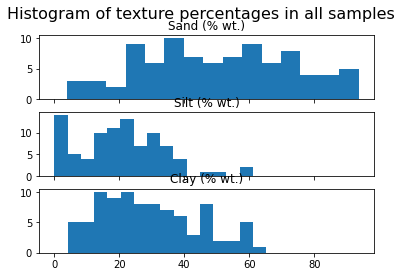

In [7]:
#histograms

fig, axes= plt.subplots(len(texture_labels_cols), sharex=True)
fig.suptitle('Histogram of texture percentages in all samples', fontsize=16)
for i, ax in enumerate(axes.flat):
  ax.hist(df[texture_labels_cols[i]], 15, histtype='bar')
  ax.set_title(texture_labels_cols[i])

In [8]:
# binning into spectral bins
print ('binning into spectral bins')
min=spec_cols[0]
max=spec_cols[-1]
step=10
bins= list(range(min, max,step))
#print(bins)

binnedSpec=pd.DataFrame()
for pair in zip(bins[:-1],bins[1:]):
  #print (pair)
  lo, hi = pair[0], pair[1]
  cols_to_bin= [str(col) for col in spec_cols if (col>=lo and col<hi)]
  binnedSpec[str(lo)]= df_spec[cols_to_bin].mean(axis=1)

binned_names= list(binnedSpec.columns)
print(f'total number of columns {len(binned_names)}')

binning into spectral bins
total number of columns 101


In [9]:
#creating a derivative frame
print('calculating derivative')
deriv_binned_spec=pd.DataFrame()
for pair in zip(binned_names[:-1],binned_names[1:]):
  wavelength, wavelength_plusone = pair[0], pair[1]
  deriv_binned_spec[wavelength]= (binnedSpec[wavelength_plusone]-binnedSpec[wavelength])/step
#print(deriv_binned_spec.shape)

derive_binned_names= list(deriv_binned_spec.columns) 
print(f'total number of columns {len(derive_binned_names)}')


calculating derivative
total number of columns 100


In [10]:
# the do-nothing transform
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array*1

In [11]:
def create_and_train_RF_regressor (data_df, label_df, name, feature_names, max_depth=10, normalize=False, pca=False,):
  X_train, X_test, y_train, y_test = scsplit(data_df, label_df, stratify = label_df, test_size=0.25, random_state=42)
  #X_train, X_test, y_train, y_test= train_test_split (data_df, label_df, test_size=0.25, random_state=42)

  if normalize:
    preprocessing = ColumnTransformer(
      [("num",  Normalizer(), feature_names)],
    )
  else:
      preprocessing = ColumnTransformer(
      [("num", IdentityTransformer(), feature_names)],
    )
  if pca:  
    pca=PCA(n_components=20)
    rf = Pipeline(
        [
            ("preprocess", preprocessing),
            ("PCA", pca),
            ("regressor", RandomForestRegressor(n_estimators=200, max_depth=max_depth, max_features=0.2)),
        ]
    )
  else:
    rf = Pipeline(
        [
            ("preprocess", preprocessing),
            ("regressor", RandomForestRegressor(n_estimators=200, max_depth=max_depth, max_features=0.2)),
        ]
    )  
    
  #rf= RandomForestRegressor(n_estimators=200, max_depth=5, max_features=0.1)
  rf.fit(X_train, y_train)

  print(f"{name} train accuracy: {rf.score(X_train, y_train):.3f}")
  print(f"{name} test accuracy: {rf.score(X_test, y_test):.3f}")

  # graphs
  if not(pca):  
    mdi_importances = pd.Series(rf[-1].feature_importances_, index=feature_names)
    ordered_mdi_importances=mdi_importances.sort_values(ascending=True)
    fig, (ax1, ax2)= plt.subplots(1,2, figsize=(30,10))
  
  
    #fig= plt.figure(figsize=(20,10))
    ax1.plot(mdi_importances) #.plot()
    ax1.set_xticklabels(feature_names,rotation=90)
    ax1.set_title(f"{name} - Random Forest Feature Importances (MDI)")
    ax1.set_xlabel('wavelength')
    #ax1.figure.tight_layout()  

    # alternative: feature importance by order of importance
    #fig= plt.figure(figsize=(20,50))
    #print(ordered_mdi_importances)
    ax2.bar(ordered_mdi_importances.index, ordered_mdi_importances) 
    ax2.set_xticklabels(ordered_mdi_importances.index, rotation=90)
    ax2.set_title(f"{name} - Random Forest Feature Importances (MDI)")
    #ax2.figure.tight_layout()

  return rf

Spectral train accuracy: 0.890
Spectral test accuracy: 0.492
binned_Spectral train accuracy: 0.889
binned_Spectral test accuracy: 0.505
deriv_binned_Spectral train accuracy: 0.904
deriv_binned_Spectral test accuracy: 0.551
normalized_Spectral train accuracy: 0.893
normalized_Spectral test accuracy: 0.309
normalized_binned_Spectral train accuracy: 0.898
normalized_binned_Spectral test accuracy: 0.267
normalized_deriv_binned_Spectral train accuracy: 0.898
normalized_deriv_binned_Spectral test accuracy: 0.371
PCA_Spectral train accuracy: 0.890
PCA_Spectral test accuracy: 0.297
PCA_binned_Spectral train accuracy: 0.888
PCA_binned_Spectral test accuracy: 0.341
PCA_deriv_binned_Spectral train accuracy: 0.886
PCA_deriv_binned_Spectral test accuracy: 0.242
PCA_normalized_Spectral train accuracy: 0.877
PCA_normalized_Spectral test accuracy: 0.272
PCA_normalized_binned_Spectral train accuracy: 0.871
PCA_normalized_binned_Spectral test accuracy: 0.274
PCA_normalized_deriv_binned_Spectral train ac

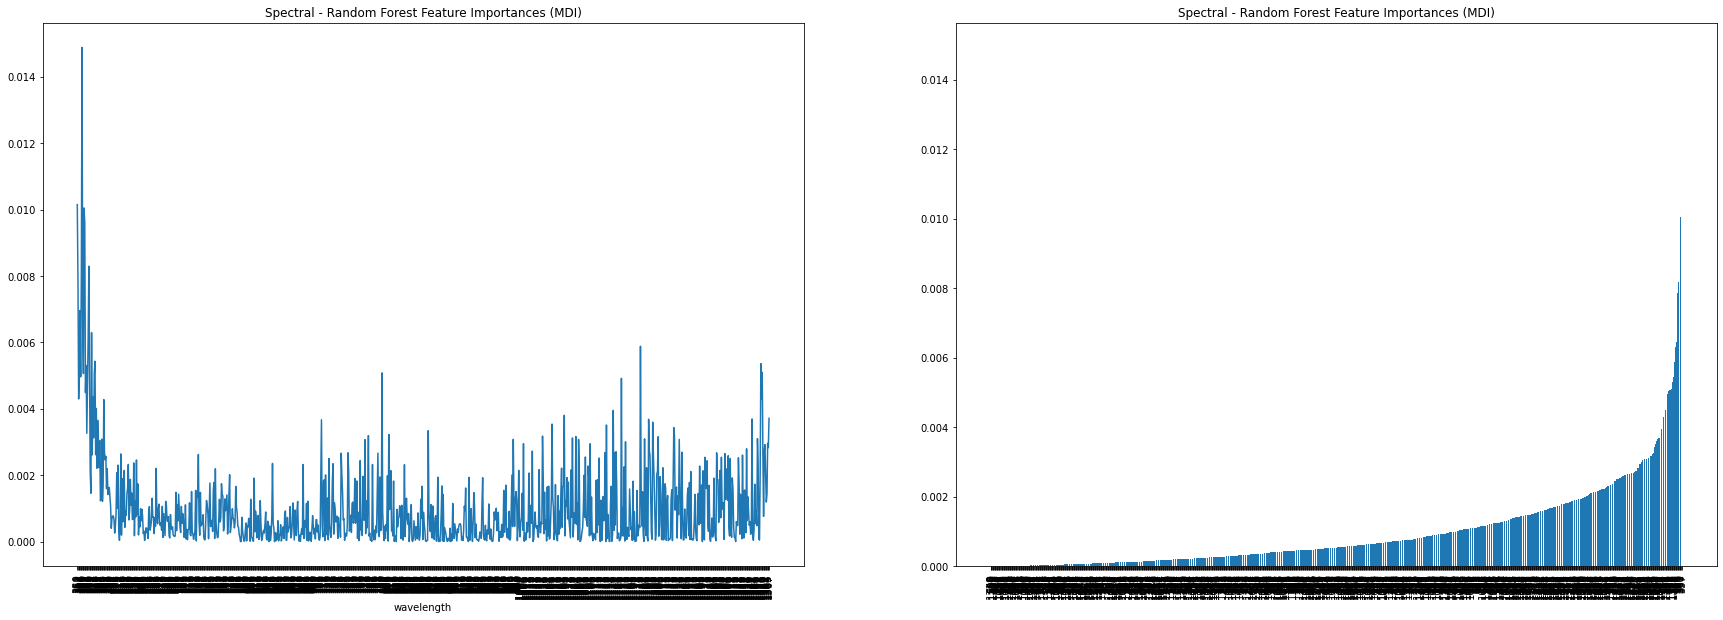

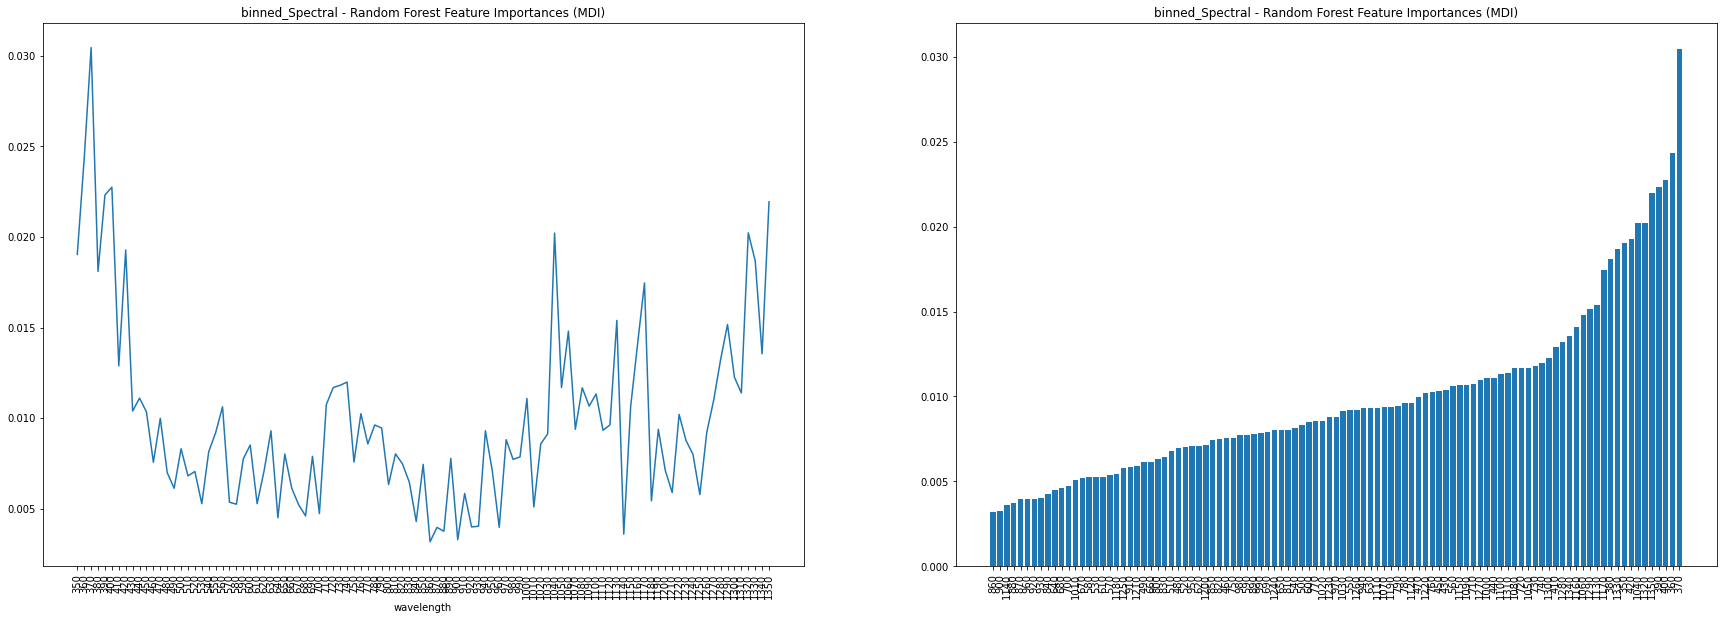

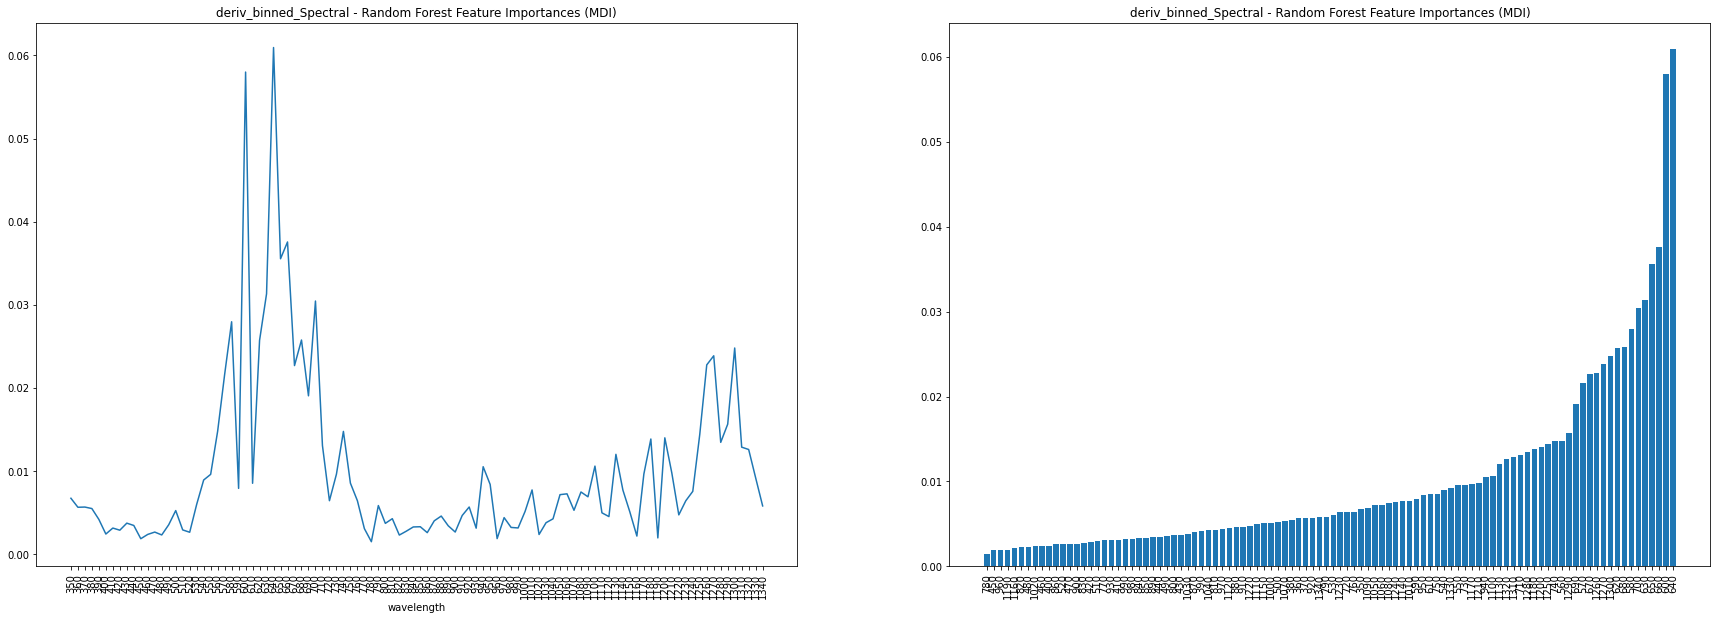

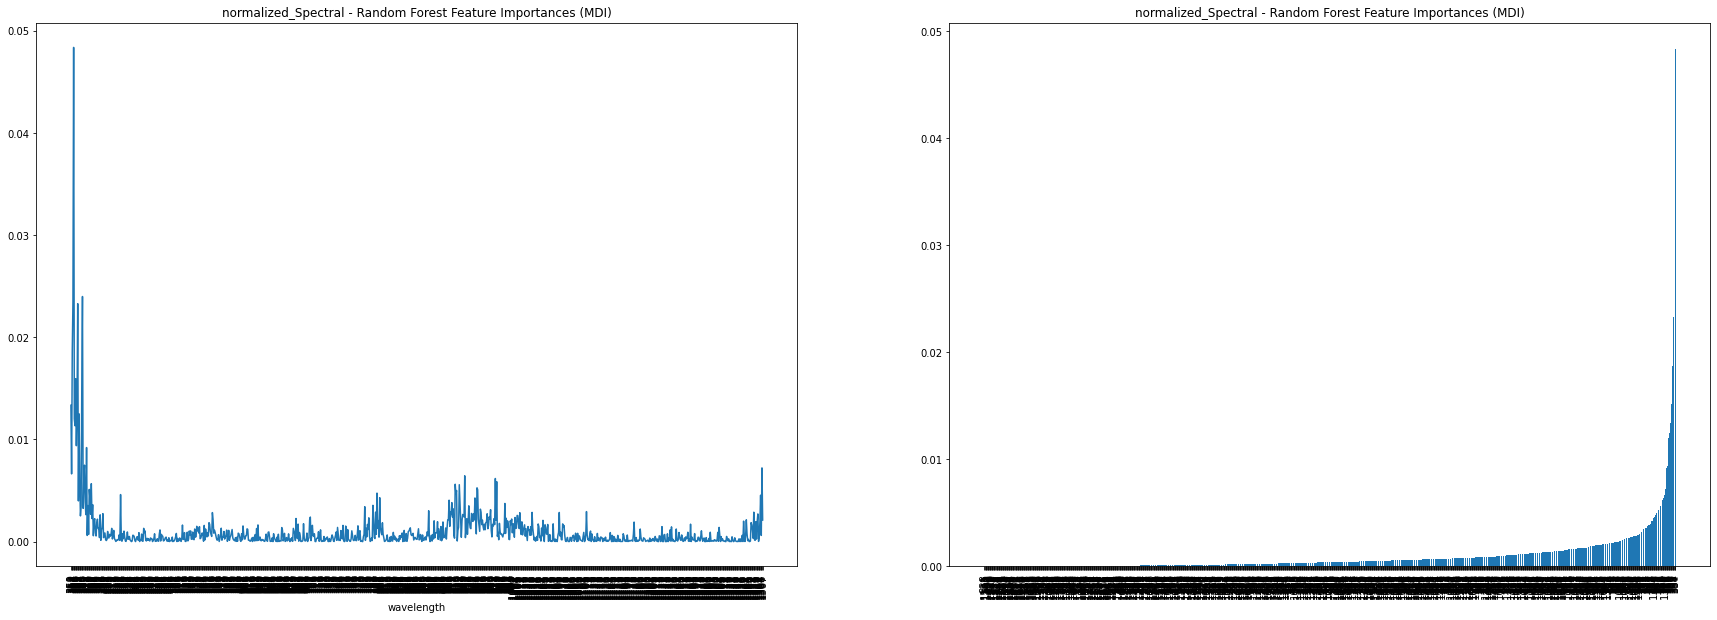

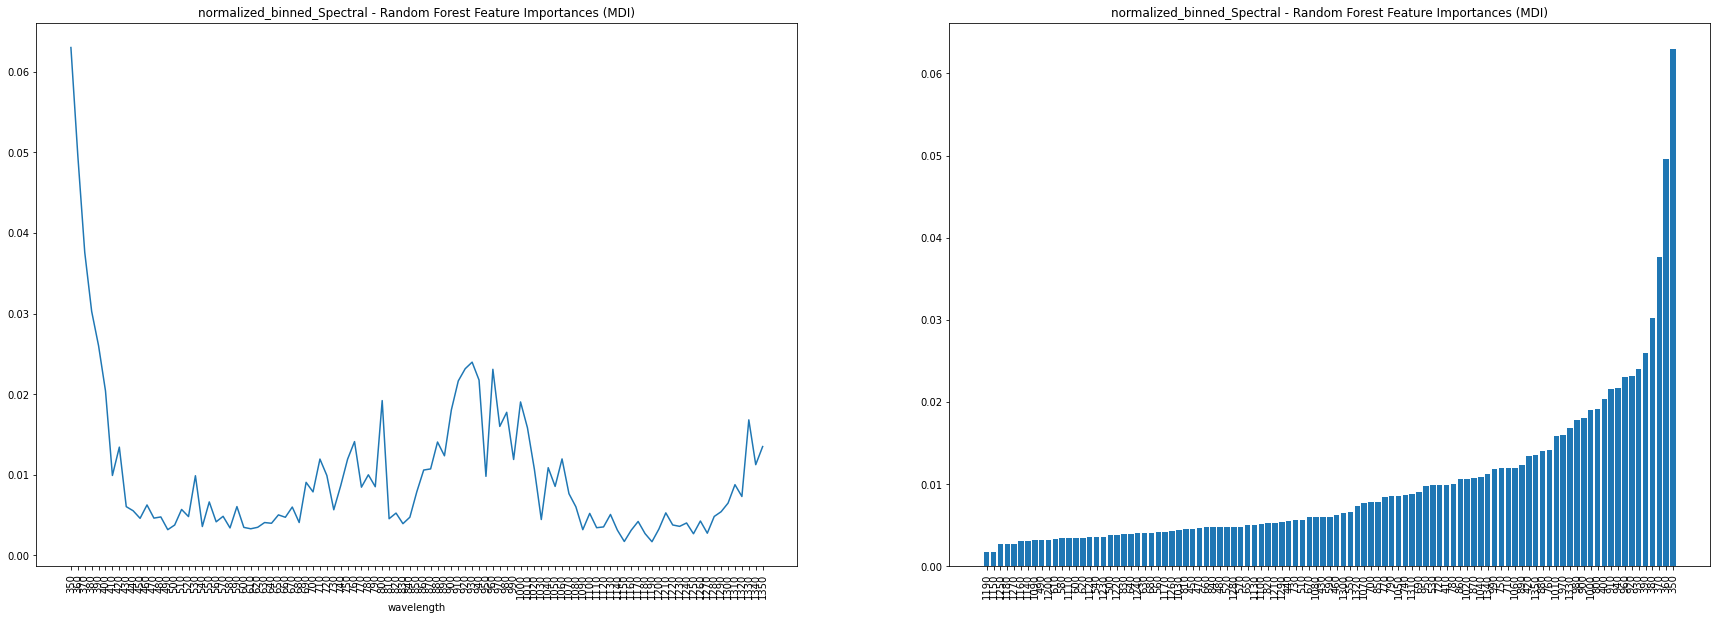

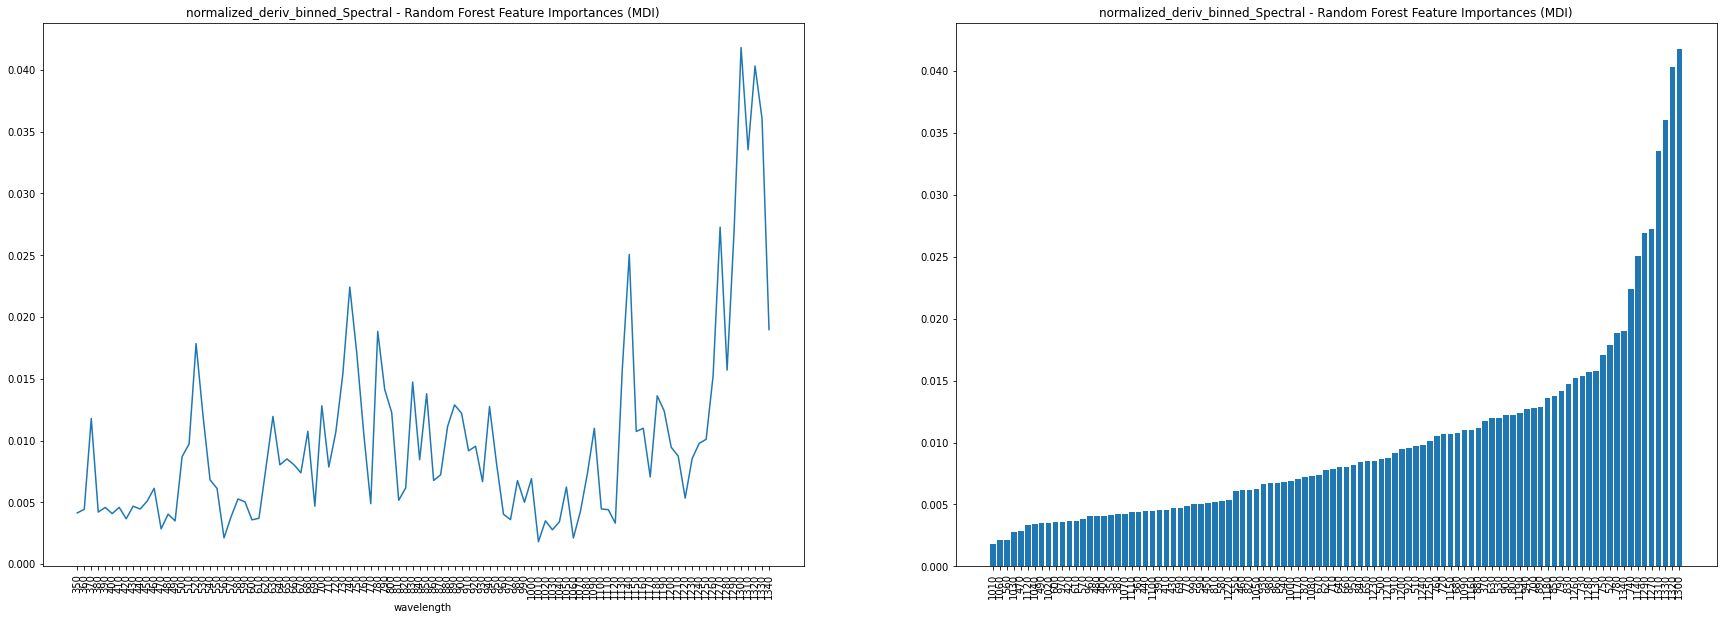

In [12]:
# run and assess several random forest regressors

spec_rf = create_and_train_RF_regressor (df_spec, label_df, "Spectral", spec_cols_str)
binned_rf = create_and_train_RF_regressor (binnedSpec, label_df, "binned_Spectral", binned_names)
deriv_binned_rf = create_and_train_RF_regressor (deriv_binned_spec, label_df, "deriv_binned_Spectral", derive_binned_names)

normalized_spec_rf = create_and_train_RF_regressor (df_spec, label_df, "normalized_Spectral", spec_cols_str, normalize=True)
normalized_binned_rf = create_and_train_RF_regressor (binnedSpec, label_df, "normalized_binned_Spectral", binned_names, normalize=True)
normalized_deriv_binned_rf = create_and_train_RF_regressor (deriv_binned_spec, label_df, "normalized_deriv_binned_Spectral", derive_binned_names, normalize=True)

PCA_spec_rf = create_and_train_RF_regressor (df_spec, label_df, "PCA_Spectral", spec_cols_str, pca=True)
PCA_binned_rf = create_and_train_RF_regressor (binnedSpec, label_df, "PCA_binned_Spectral", binned_names, pca=True)
PCA_deriv_binned_rf = create_and_train_RF_regressor (deriv_binned_spec, label_df, "PCA_deriv_binned_Spectral", derive_binned_names, pca=True)

PCA_normalized_spec_rf = create_and_train_RF_regressor (df_spec, label_df, "PCA_normalized_Spectral", spec_cols_str, normalize=True, pca=True)
PCA_normalized_binned_rf = create_and_train_RF_regressor (binnedSpec, label_df, "PCA_normalized_binned_Spectral", binned_names, normalize=True, pca=True)
PCA_normalized_deriv_binned_rf = create_and_train_RF_regressor (deriv_binned_spec, label_df, "PCA_normalized_deriv_binned_Spectral", derive_binned_names, normalize=True, pca=True)


# Further Directions

* predicting the other attributes and then calculating clay as 100%-others
* training on all sample sites except one, then predict on that one
* implementing the preprocessing as transforms and training an ensamble of estimators


Refernces: 

Francos, N., Gholizadeh, A., Demattê, J. A. M., & Ben-Dor, E. (2022). Effect of the internal soil standard on the spectral assessment of clay content. Geoderma, 420, 115873.

Hobley, E. U., & Prater, I. (2019). Estimating soil texture from vis–NIR spectra. European Journal of Soil Science, 70(1), 83-95.

Procedural Refernces:

Continuous data stratification
https://danilzherebtsov.medium.com/continuous-data-stratification-c121fc91964b

Pipelines and the identity transformation for implementing normalization toggle
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://medium.com/@literallywords/sklearn-identity-transformer-fcc18bac0e98